**Image Processing Laboratory (045108) - Meeting 4/4**  

Signal and Image Processing Lab (SIPL) & Vision and Image Sciences Lab (VISL)  
The Andrew and Erna Viterbi Faculty of Electrical and Computer Engineering    
Technion - Israel Institute of Technology

In [112]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import color, feature, filters, measure, morphology, io, transform, util, exposure, metrics
from lab_code import flir_image_extractor
from lab_code.apply_noise import apply_noise

# Thermal constants
THERMAL_MIN_VAL = 9620
THERMAL_MAX_VAL = 18070
THERMAL_NUM_BINS = 8451


# Helper Functions

In [113]:
def visual_prep(filename, convert_to_grayscale=True):
    """
    Prepares an image for the lab by reading, converting to grayscale (if necessary),
    normalizing, and resizing.

    Args:
        filename (str): Path to the image file.
        convert_to_grayscale (bool, optinal): Flag to control grayscale conversion.
            Defaults to True.

    Returns:
        numpy.ndarray: The prepared image array.
    """

    image = io.imread(filename)
    if convert_to_grayscale and len(image.shape) == 3:
       image = color.rgb2gray(image)

    NEW_WIDTH = 1600
    # Resize the image to TARGET_WIDTH columns keeping the original aspect ratio
    height, width = image.shape[:2]
    resize_factor = width / NEW_WIDTH
    new_height = int(height / resize_factor)

    image = transform.resize(image, (new_height, NEW_WIDTH), anti_aliasing=True)
    image = util.img_as_ubyte(image)

    return image


def thermal_prep(filename):
    """
    Prepares a FLIR thermal image for the lab by reading it.

    Args:
        filename (str): Path to the FLIR thermal image file.

    Returns:
        numpy.ndarray: The prepared thermal image.
    """

    image_extractor = flir_image_extractor.FlirImageExtractor()
    image_extractor.process_image(filename)
    thermal = image_extractor.extract_thermal_image()

    return thermal


def thermal_prep_uint8(filename):
    """
    Prepares a FLIR thermal image for the lab by reading and converting it to uint8 format.

    Args:
        filename (str): Path to the FLIR thermal image file.

    Returns:
        numpy.ndarray: The prepared thermal image in uint8 format.
    """

    thermal = thermal_prep(filename)

    # Create a copy of the input image
    qth = np.copy(thermal).astype(np.float32)

    # Divide the pixel value range into 'levels' number of buckets
    levels = 256
    buckets = np.linspace(THERMAL_MIN_VAL, THERMAL_MAX_VAL, levels + 1)

    # Quantize the image
    for i in range(levels):
        mask = (thermal >= buckets[i]) & (thermal < buckets[i + 1])
        qth[mask] = i

    qth = qth.astype(np.uint8)

    return qth


def detect_and_visualize_bounding_boxes(binary_mask, image, denoising_level=10, max_boxes=5):
    """
    Detects regions in a binary mask and visualize them with bounding boxes on the original image.

    Args:
    - binary_mask (np.ndarray): Binary mask where the objects/regions are represented by non-zero pixels.
    - image (np.ndarray): Original image (grayscale or RGB) to display the bounding boxes on.
    - denoising_level (int, optional): Amount of denoising to perform on the binary mask. A larger value applies
        stronger denoisng by removing larger objects. Default is 10.
    - max_boxes (int, optiona;): Maximum number of bounding boxes to display, sorted by area. Default is 5.

    Returns:
    - List of tuples: Each tuple contains the coordinates of the bounding box in the format
        ((min_col, min_row), (max_col, max_row)).
    """

    # Apply morphological operations to clean the image
    selem = morphology.square(denoising_level)
    cleaned_mask = morphology.opening(binary_mask, selem)

    # Label connected regions (blobs) in the binary mask
    labeled_regions, num_regions = measure.label(cleaned_mask, return_num=True)

    # Loop through each labeled region to find bounding boxes
    bounding_boxes = []
    for region in measure.regionprops(labeled_regions):
        min_row, min_col, max_row, max_col = region.bbox
        bounding_boxes.append(((min_col, min_row), (max_col, max_row)))

    # Sort the rectangles by area in descending order and keep only the largest
    bounding_boxes = sorted(bounding_boxes, key=lambda x: (x[1][0] - x[0][0]) * (x[1][1] - x[0][1]), reverse=True)[:max_boxes]

    # Visualize the result
    fig, ax = plt.subplots(figsize=(10, 4))

    if len(image.shape) == 2:  # grayscale image
        ax.imshow(image, cmap='gray')
    else:                      # RGB image
        ax.imshow(image)

    for rect in bounding_boxes:
        (min_col, min_row), (max_col, max_row) = rect
        rect_patch = plt.Rectangle((min_col, min_row), max_col - min_col, max_row - min_row,
                                   edgecolor='red', facecolor='none', linewidth=2)
        ax.add_patch(rect_patch)

    plt.title(f'Original Image with Detected Bounding Boxes')
    plt.tight_layout()
    plt.show()

    return bounding_boxes


def extract_image_patch(image, bounding_box):
    """
    Extracts a grayscale patch from an RGB image based on the given bounding box coordinates.

    Args:
    - image (np.ndarray): The original RGB image from which to extract the patch.
    - bounding_box (tuple): A tuple representing the bounding box in the format ((min_col, min_row), (max_col, max_row)).

    Returns:
    - nd.ndarray: A grayscale patch from the image corresponding to the bounding box.
    """
    # Convert the RGB image to grayscale
    if image.ndim == 3:#added this line for q 4
        grayscale_image = color.rgb2gray(image)
    else:
        grayscale_image = image
    
    

    # Extract the bounding box coordinates
    (min_col, min_row), (max_col, max_row) = bounding_box

    # Extract the grayscale patch from the bounding box
    grayscale_patch = grayscale_image[min_row:max_row, min_col:max_col]

    return grayscale_patch



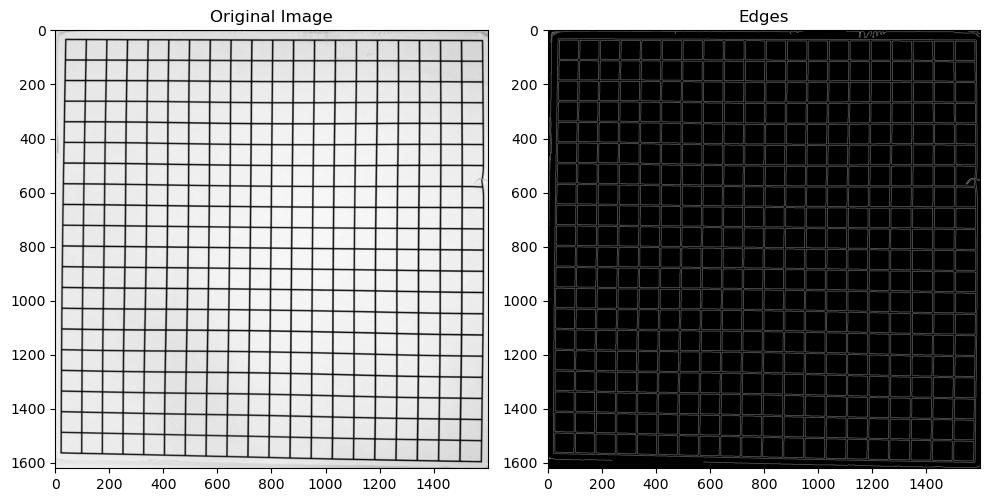

In [115]:
#load and print empty board, use canny to detect edges
empty_board = visual_prep('images/IMG_9540.jpeg', convert_to_grayscale=True)
canny_low_threshold = 0
board_edges = feature.canny(empty_board, sigma=1.5, low_threshold=0)

# Show image and edges
plt.figure(figsize=(10, 8))
plt.subplot(1,2,1)
plt.imshow(empty_board, cmap=plt.cm.gray)
plt.title('Original Image')

plt.subplot(1,2,2)
plt.imshow(board_edges, cmap=plt.cm.gray)
plt.title('Edges')

plt.tight_layout()
plt.show()

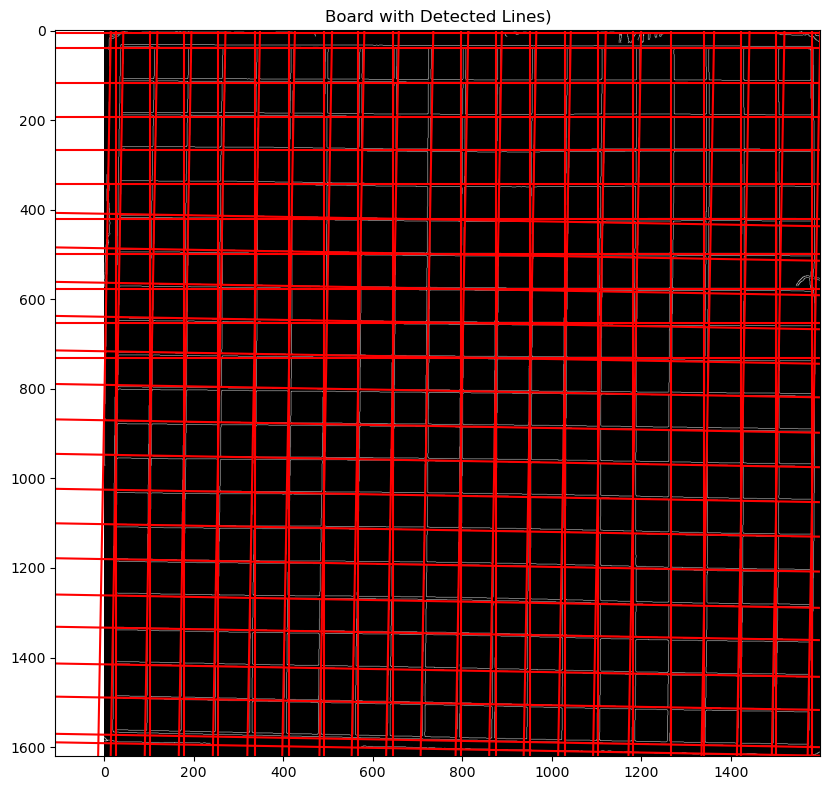

In [117]:
#use hough transform to detect the lines
hough_peaks_threshold = 0.3
hough_space, angles, distances = transform.hough_line(board_edges)
strong_peaks = transform.hough_line_peaks(
    hough_space, angles, distances, threshold=hough_peaks_threshold * np.max(hough_space))

strong_lines = []
for _, angle, distance in zip(*strong_peaks):
    x0, y0 = distance * np.array([np.cos(angle), np.sin(angle)])
    slope = np.tan(angle + np.pi/2)
    strong_lines.append(((x0, y0), slope))

board_edges_rgb = color.gray2rgb(board_edges.astype(float))

#image with detected lines in red
plt.figure(figsize=(10, 8))
axis = plt.imshow(board_edges_rgb)
for (x0, y0), slope in strong_lines:
    plt.axline((x0, y0), slope=slope, color='red')
plt.title('Board with Detected Lines)')
plt.tight_layout()
plt.show()


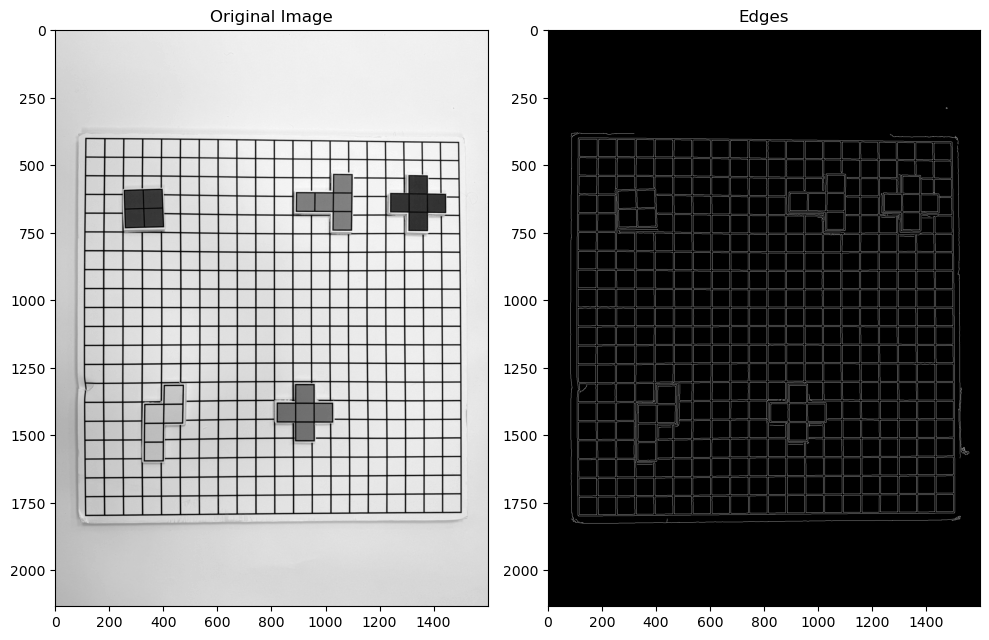

In [118]:
#question 2
tetris_board = visual_prep('images/tetris.png', convert_to_grayscale=True)
canny_low_threshold = 0
tetris_edges = feature.canny(tetris_board, sigma=1.5, low_threshold=0)

# print board with pieces & edges 
plt.figure(figsize=(10, 8))
plt.subplot(1,2,1)
plt.imshow(tetris_board, cmap=plt.cm.gray)
plt.title('Original Image')

plt.subplot(1,2,2)
plt.imshow(tetris_edges, cmap=plt.cm.gray)
plt.title('Edges')

plt.tight_layout()
plt.show()

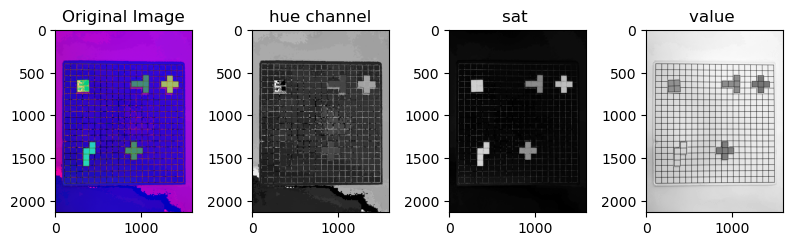

In [121]:
#load the board in rgb

tetris_board_color = visual_prep('images/tetris.png', convert_to_grayscale=False)
canny_low_threshold = 0
#we first tried using just a grayscale threshold on rgb image and couldnt seperate the yellow piece
#so switch the image to HSV channels to see if well be able to seperate better

tetris_hsv = color.rgb2hsv(tetris_board_color)

tetris_h = tetris_hsv[:,:,0]
tetris_s = tetris_hsv[:,:,1]
tetris_v = tetris_hsv[:,:,2]


plt.figure(figsize=(10, 8))
plt.subplot(1,5,1)
plt.imshow(tetris_hsv )
plt.title('Original Image')

plt.subplot(1,5,2)
plt.imshow(tetris_h, cmap=plt.cm.gray)
plt.title('hue channel')

plt.subplot(1,5,3)
plt.imshow(tetris_s, cmap=plt.cm.gray)
plt.title('sat ')

plt.subplot(1,5,4)
plt.imshow(tetris_v, cmap=plt.cm.gray)
plt.title('value ')


plt.tight_layout()
plt.show()



Text(0.5, 1.0, 'tetris')

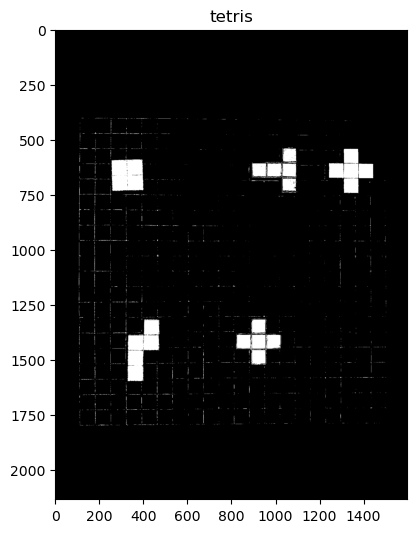

In [122]:
#pick sat channel and use threshhold 0.5 to tuen to bw
bw_thres = 0.5

tetris_bw = tetris_s > bw_thres
tetris_bw = tetris_bw.astype(np.uint8)
# Show image and edges
plt.figure(figsize=(10, 8))
plt.subplot(1,2,1)
plt.imshow(tetris_bw, cmap=plt.cm.gray)
plt.title('tetris')

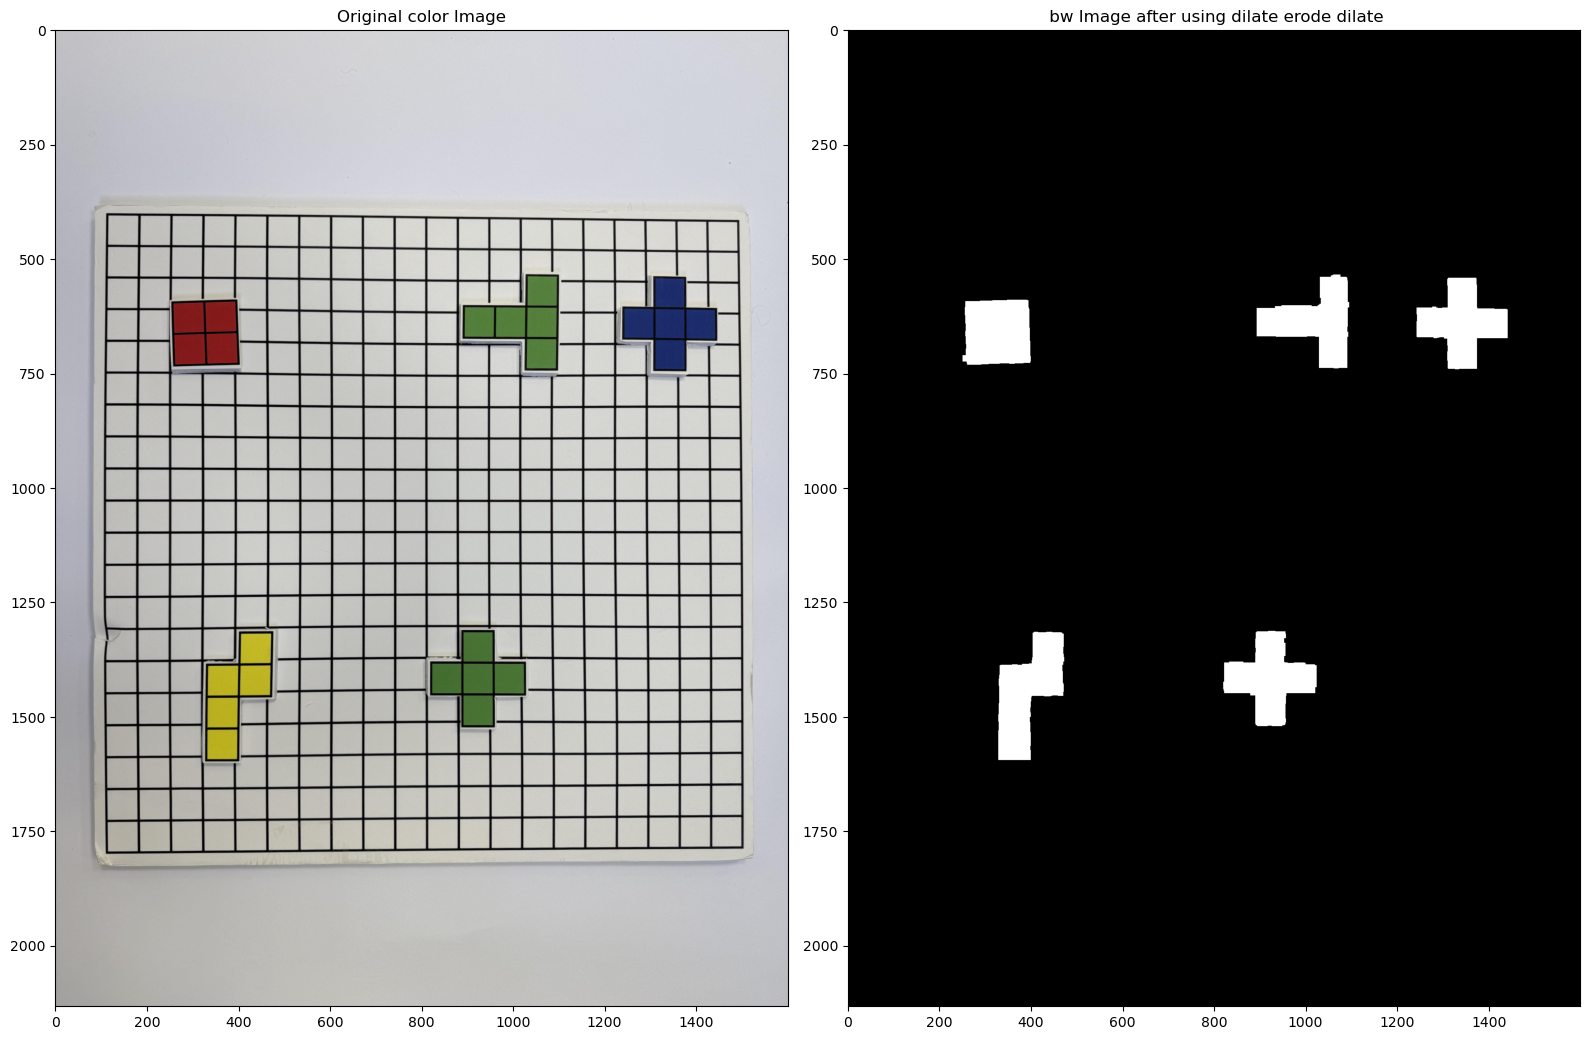

In [123]:
#using 2 diff kernal and dilate -> erode -> dilate we managed to clean the image quite well and get rhe pieces in bw
strel1 = morphology.square(8)
strel2 = morphology.square(16)

mask = morphology.dilation(tetris_bw, strel1)
mask = morphology.erosion(mask, strel2)
mask = morphology.dilation(mask, strel1)


# results
plt.figure(figsize=(16, 16))

plt.subplot(1, 2, 1)
plt.imshow(tetris_board_color, cmap='gray')
plt.title('Original color Image')

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title(' bw Image after using dilate erode dilate')

plt.tight_layout()
plt.show()


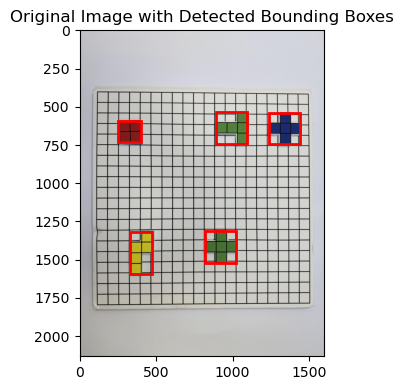

[((819, 1314), (1023, 1522)),
 ((892, 536), (1094, 741)),
 ((328, 1316), (472, 1596)),
 ((1241, 543), (1440, 742)),
 ((250, 591), (399, 733))]

In [124]:

detect_and_visualize_bounding_boxes(mask, tetris_board_color, max_boxes=5)

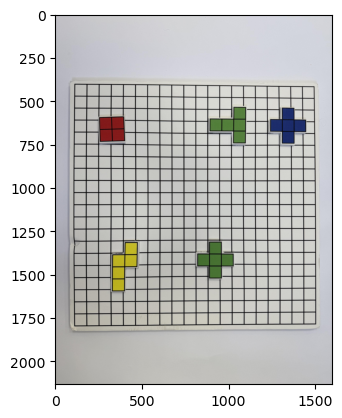

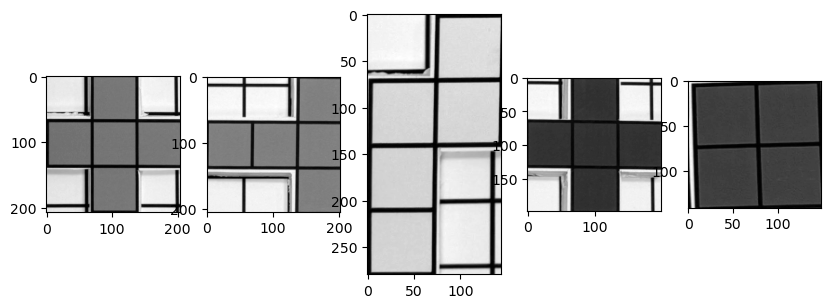

In [125]:
plt.imshow(tetris_board_color, cmap='gray')
# use the results above to extract the cards using the given func and locations
plus_g = extract_image_patch(tetris_board_color, ((819, 1314), (1023, 1522)))
T_green = extract_image_patch(tetris_board_color, ((892, 536), (1094, 741)))
yellow = extract_image_patch(tetris_board_color, ((328, 1316), (472, 1596)))
plus_b = extract_image_patch(tetris_board_color, ((1241, 543), (1440, 742)))
square_r = extract_image_patch(tetris_board_color, ((250, 591), (399, 733)))
plt.figure(figsize=(10, 8))
plt.subplot(1, 5, 1)
plt.imshow(plus_g, cmap='gray')
plt.subplot(1, 5, 2)
plt.imshow(T_green, cmap='gray')
plt.subplot(1, 5, 3)
plt.imshow(yellow, cmap='gray')
plt.subplot(1, 5, 4)
plt.imshow(plus_b, cmap='gray')
plt.subplot(1, 5, 5)
plt.imshow(square_r, cmap='gray')

according to lab assistent instructions and technical difficulties with the thermal camera we skipped question 3 and moved to 4 and 5

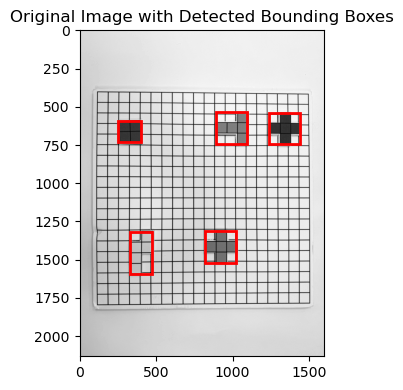

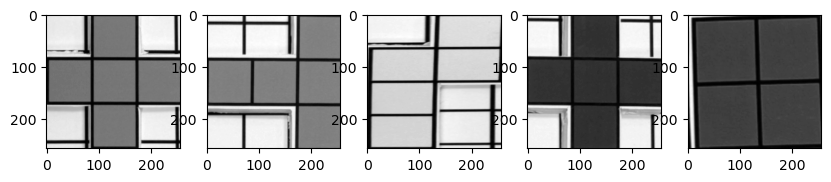

In [126]:
#Question 4
#fitting cards, we decided to try to resize all the cards to the same dim and use ssim to fit our guess to the 5 options 
#use mask on itself to find the 5 bw cards
detect_and_visualize_bounding_boxes(mask, tetris_board, max_boxes=5)
#extract the bw cardes
plus_gbw = extract_image_patch(tetris_board, ((819, 1314), (1023, 1522)))#.astype(np.uint8)
T_greenbw = extract_image_patch(tetris_board, ((892, 536), (1094, 741)))#.astype(np.uint8)
yellowbw = extract_image_patch(tetris_board, ((328, 1316), (472, 1596)))#.astype(np.uint8)
plus_bbw = extract_image_patch(tetris_board, ((1241, 543), (1440, 742)))#.astype(np.uint8)
square_rbw = extract_image_patch(tetris_board, ((250, 591), (399, 733)))#.astype(np.uint8)

#resize the cards
plus_g_bw = transform.resize(plus_gbw, (256, 256), anti_aliasing=True)
T_green_bw = transform.resize(T_greenbw, (256, 256), anti_aliasing=True)
yellow_bw = transform.resize(yellowbw, (256, 256), anti_aliasing=True)
plus_b_bw = transform.resize(plus_bbw, (256, 256), anti_aliasing=True)
square_r_bw = transform.resize(square_rbw, (256, 256), anti_aliasing=True)

plt.figure(figsize=(10, 8))
plt.subplot(1, 5, 1)
plt.imshow(plus_g_bw, cmap='gray')
plt.subplot(1, 5, 2)
plt.imshow(T_green_bw, cmap='gray')
plt.subplot(1, 5, 3)
plt.imshow(yellow_bw, cmap='gray')
plt.subplot(1, 5, 4)
plt.imshow(plus_b_bw, cmap='gray')
plt.subplot(1, 5, 5)
plt.imshow(square_r_bw, cmap='gray')


Randomly selected test card: Plus Green
SSIM with Plus Green: 1.0000
SSIM with T Green: 0.5391
SSIM with Yellow: 0.3755
SSIM with Plus Blue: 0.5475
SSIM with Square Red: 0.3248

Best guess: Plus Green (SSIM score: 1.0000)


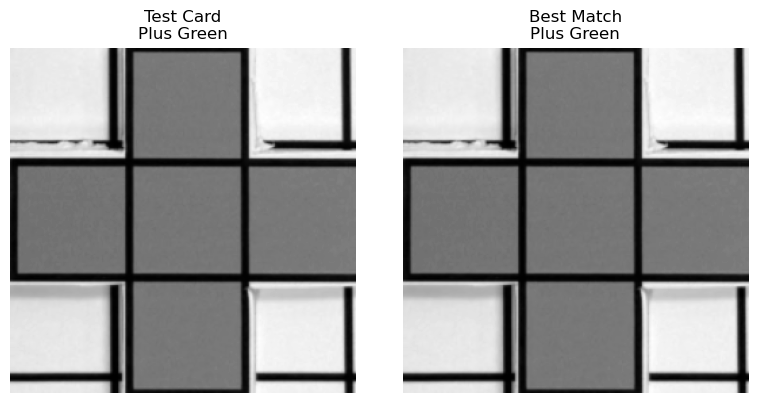

In [129]:
import random
#init card options
card_names = ["Plus Green", "T Green", "Yellow", "Plus Blue", "Square Red"]
cards = [plus_g_bw, T_green_bw, yellow_bw, plus_b_bw, square_r_bw]
#pick random card
rand_index = random.randint(0, len(cards) - 1)
test = cards[rand_index]
test_name = card_names[rand_index]

print(f"Randomly selected test card: {test_name}")
#look for best match using ssim as the criterion
best_guess = None
best_name = ""
max_score = -1
for img, name in zip(cards, card_names):
    #images to float in range [0,1]
    test_norm = test.astype(np.float32)
    img_norm = img.astype(np.float32)
    
    # measure ssim
    score = metrics.structural_similarity(test_norm, img_norm, data_range=1.0)
    print(f"SSIM with {name}: {score:.4f}")

    if score > max_score:
        max_score = score
        best_guess = img
        best_name = name

print(f"\nBest guess: {best_name} (SSIM score: {max_score:.4f})")

# print test and best match
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(test, cmap='gray')
plt.title(f"Test Card\n{test_name}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(best_guess, cmap='gray')
plt.title(f"Best Match\n{best_name}")
plt.axis('off')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Noisy color Image')

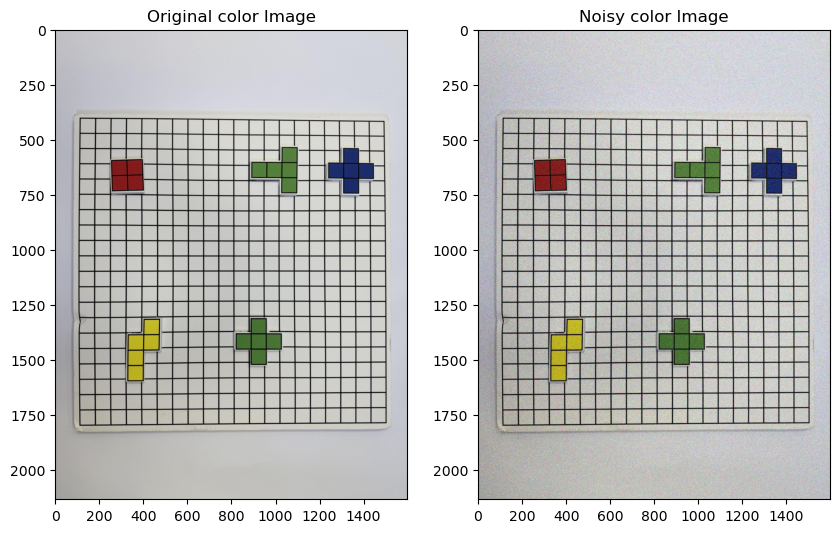

In [128]:
#q5
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.imshow(tetris_board_color)
plt.title('Original color Image')
noise_tetris = apply_noise(tetris_board_color, 1)
plt.subplot(1, 2, 2)
plt.imshow(noise_tetris)
plt.title('Noisy color Image')

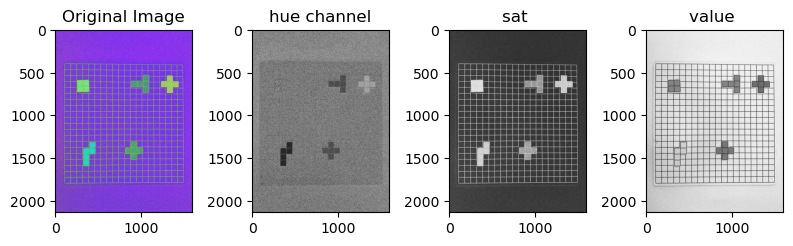

In [133]:

#transform the noisy board to hsv to see if we can visually pick a channel thatll be easy to threshhold

ntetris_hsv = color.rgb2hsv(noise_tetris)

ntetris_h = ntetris_hsv[:,:,0]
ntetris_s = ntetris_hsv[:,:,1]
ntetris_v = ntetris_hsv[:,:,2]


plt.figure(figsize=(10, 8))
plt.subplot(1,5,1)
plt.imshow(ntetris_hsv )
plt.title('Original Image')

plt.subplot(1,5,2)
plt.imshow(ntetris_h, cmap=plt.cm.gray)
plt.title('hue channel')

plt.subplot(1,5,3)
plt.imshow(ntetris_s, cmap=plt.cm.gray)
plt.title('sat ')

plt.subplot(1,5,4)
plt.imshow(ntetris_v, cmap=plt.cm.gray)
plt.title('value ')


plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'tetris')

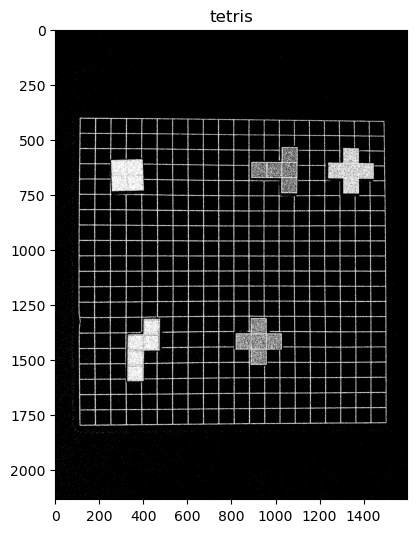

In [134]:

nbw_thres = 0.6
#pick sat channel like q2
ntetris_bw = ntetris_s > nbw_thres
ntetris_bw = ntetris_bw.astype(np.uint8)

# bw image
plt.figure(figsize=(10, 8))
plt.subplot(1,2,1)
plt.imshow(ntetris_bw, cmap=plt.cm.gray)
plt.title('tetris')

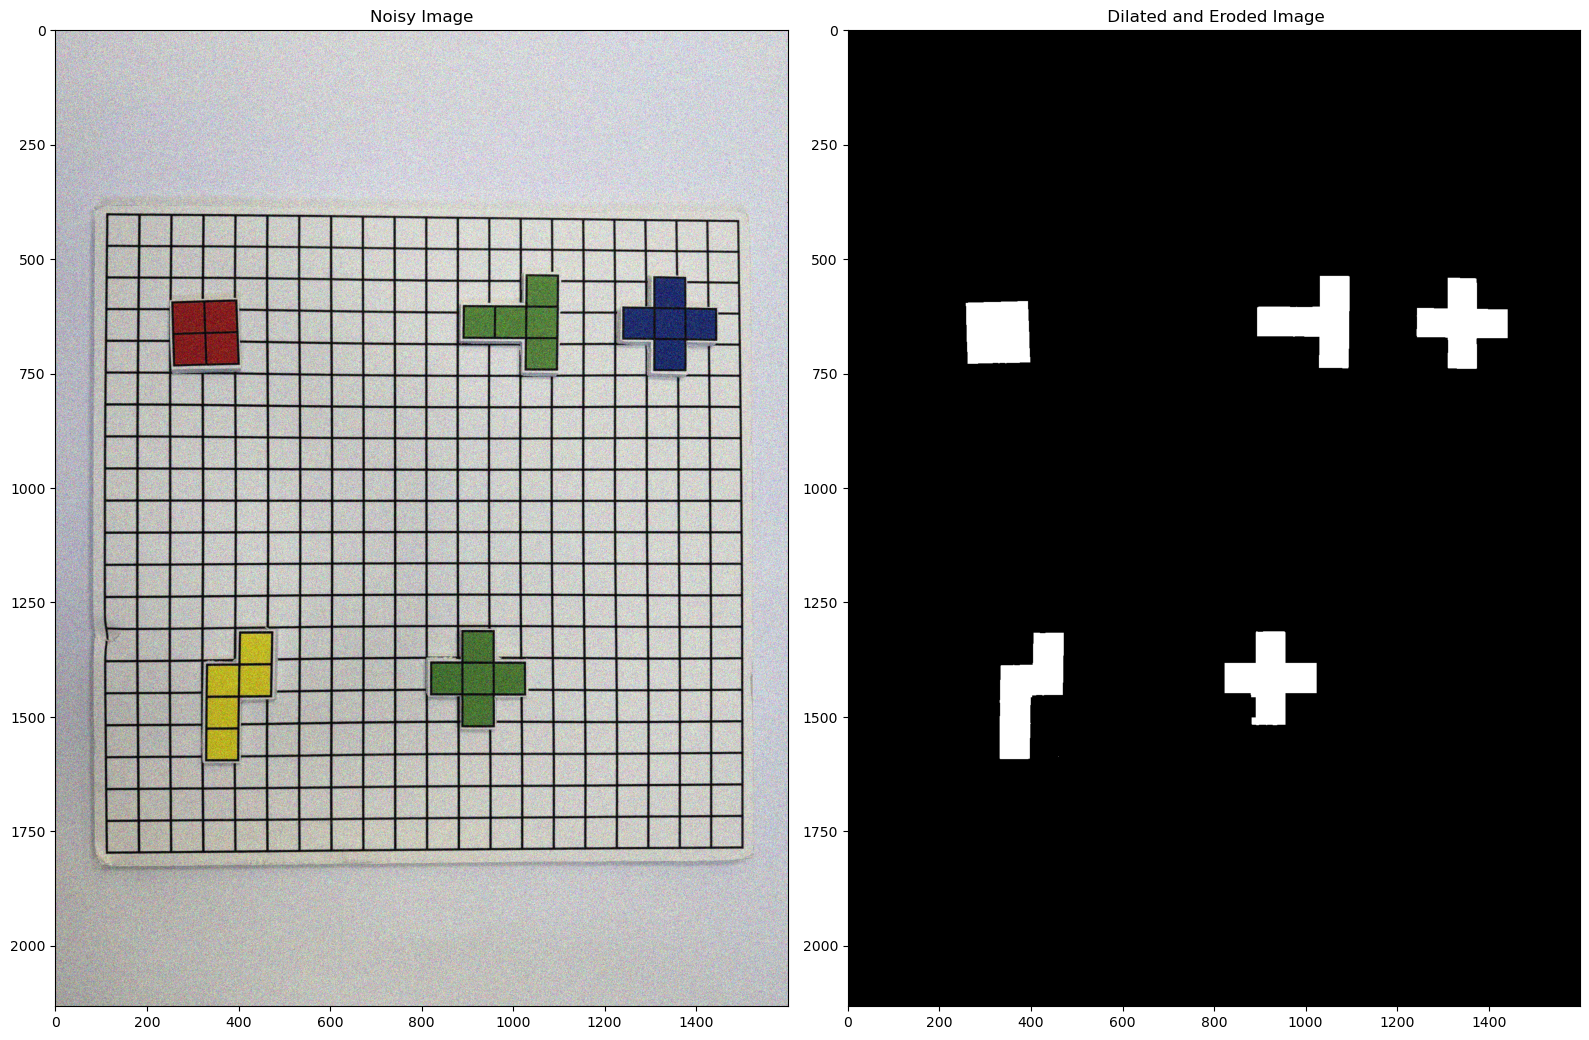

In [135]:
#using 2 diff kernels well erode and dilate to clean the noise best we can

strel1 = morphology.square(4)

maskn = morphology.dilation(ntetris_bw, strel1)
strel2 = morphology.square(12)
maskn = morphology.erosion(maskn, strel2)


plt.figure(figsize=(16, 16))

plt.subplot(1, 2, 1)
plt.imshow(noise_tetris, cmap='gray')
plt.title('Noisy Image')

plt.subplot(1, 2, 2)
plt.imshow(maskn, cmap='gray')
plt.title(' Dilated and Eroded Image')

plt.tight_layout()
plt.show()


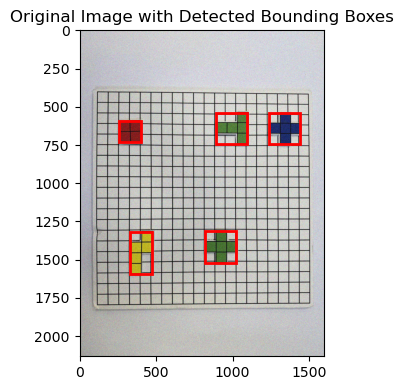

[((822, 1315), (1023, 1520)),
 ((893, 539), (1095, 741)),
 ((1241, 543), (1440, 742)),
 ((331, 1318), (471, 1594)),
 ((258, 594), (398, 731))]

In [136]:
detect_and_visualize_bounding_boxes(maskn, noise_tetris, max_boxes=5)

we can display the cards caught with simple codeextract and plot like previous question, but that was not reqiured in this section.\
and a final note, \
Thank you very much nurit for a fun and interesting lab experience!!!